In [1]:
import math
import random
import networkx as nx
import gurobipy as gp
import matplotlib.pyplot as plt

In [78]:
"""distance: euclidean distance between (x1,y1) and (x2,y2)"""
def distance(x1,y1,x2,y2):
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

In [79]:
"""make_data: compute matrix distance based on euclidean distance"""
def make_data(n):
    V = range(1,n+1)
    x = dict([(i,random.random()) for i in V])
    y = dict([(i,random.random()) for i in V])
    
    c = {}
    points = []
    for i in V:
        points.append((x[i],y[i]))
        for j in V:
            if j > i:
                c[i,j] = distance(x[i],y[i],x[j],y[j])
    return V,c, points

In [80]:
n = 20
seed = 1
random.seed(seed)
V,c,points = make_data(n)

#points

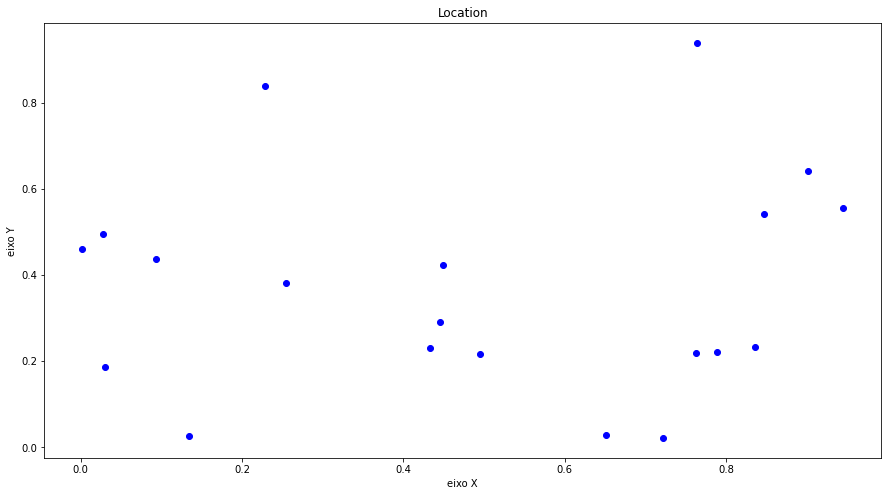

In [81]:
X = [x[0] for x in points]
Y = [y[1] for y in points]


plt.figure(figsize=(15,8))
plt.scatter(X,Y,color='blue')

#for t in range(n):
#    plt.annotate(str(t), xy=(X[t],Y[t]), xytext = (X[t]+0.5, Y[t]+1), color='red')

plt.xlabel("eixo X")
plt.ylabel("eixo Y")
plt.title("Location")
plt.show()

In [82]:
def solve_tsp(V,c):
    
    # elimination subtour
    def addcut(cut_edges):
        print("teste")
        G = nx.Graph()
        G.add_edges_from(cut_edges)
        Components = list(nx.connected_components(G))

        if len(list(Components)) == 1:
            print("encontrou somente uma componente")
            return False
        
        for S in list(Components):
            print("componente maior que 1")
            if (len(S)<=n-1):
                model.addConstr(gp.quicksum(x[i,j] for i in S for j in S if j>i) <= len(S)-1)
                print("cut: len(%s) <= %s" % (S,len(S)-1))
        
        return True

    # model
    model = gp.Model("tsp")

    # silent/verbose mode
    model.Params.OutputFlag = 0 
    
    # variables
    x = {}
    for i in V:
        for j in V:
            if j > i:
                x[i,j] = model.addVar(ub=1, name="x(%s,%s)"%(i,j))
    model.update()
    
    # constraints assigment
    for i in V:
        model.addConstr(gp.quicksum(x[j,i] for j in V if j < i) + gp.quicksum(x[i,j] for j in V if j > i) == 2, "degree(%s)"%i)
    
    model.setObjective(gp.quicksum(c[i,j]*x[i,j] for i in V for j in V if j > i), gp.GRB.MINIMIZE)

    # cut stratege
    EPS = 1.e-6
    while True:
        model.optimize()
        edges = []
        for (i,j) in x:
            if x[i,j].X > EPS:
                edges.append((i,j))

        if addcut(edges) == False:
            # integer variables, components connected: solution found
            if model.IsMIP:     
                break
            # all components connected, switch to integer model
            for (i,j) in x: 
                x[i,j].VType = "B"

            model.update()

    # get objval
    objval = model.ObjVal

    # get tour
    val_edges = []
    for (i,j) in x:
        if j > i:
            if x[i,j].X > 0.5:
                val_edges.append((i,j))

    return objval, val_edges

teste
encontrou somente uma componente
teste
componente maior que 1
cut: len({1, 4, 6, 9, 10, 14, 17, 20}) <= 7
componente maior que 1
cut: len({3, 19, 2, 18}) <= 3
componente maior que 1
cut: len({12, 5, 15}) <= 2
componente maior que 1
cut: len({7, 8, 11, 13, 16}) <= 4
teste
encontrou somente uma componente
Optimal tour: [(1, 4), (1, 20), (2, 11), (2, 18), (3, 17), (3, 19), (4, 6), (5, 7), (5, 12), (6, 15), (7, 16), (8, 11), (8, 13), (9, 14), (9, 20), (10, 14), (10, 17), (12, 15), (13, 16), (18, 19)]
Optimal cost:  3.78


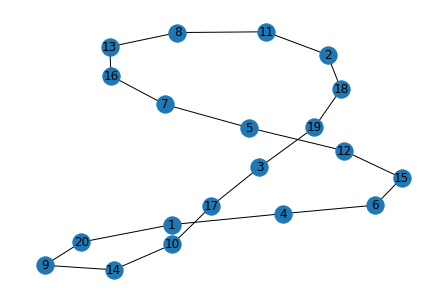

In [83]:
obj, tour_edges = solve_tsp(V,c)

print("Optimal tour:", tour_edges)
print("Optimal cost: ", round(obj,2))

G = nx.Graph()
G.add_edges_from(tour_edges)

nx.draw(G,with_labels="True")